# How does modularity of the data affect the convergence of the batched method for cold starts?

Modularity in a network is a measure of the relative density of links inside communities compared to links between communities. It's computed as the fraction of the edges that fall within communities minus the expected fraction of edges if the edges were distributed at random.

### Libraries

In [137]:
import numpy as np
from utils import compute_modularity
import matplotlib.pyplot as plt
from utils import *
from samplers import *
from Neal_samplers import *
import pandas as pd

### Inizialitations

In [103]:
p = 0.17
q = 0.08
n = 400
k = 4
n_k = 100
T = 500
burn_in = 0
alpha = 0.3

I = -2 * np.log((p*q)**0.5 +((1-p)* (1-q))**0.5 )
theoretical_threshold = np.exp(-n*I / k) # for later use

In [104]:
np.random.seed(0)

In [105]:
z_ex = np.repeat(np.arange(k), n_k)

### Some quick empirical analysis

0.1621836427068202 0.005115527145884416


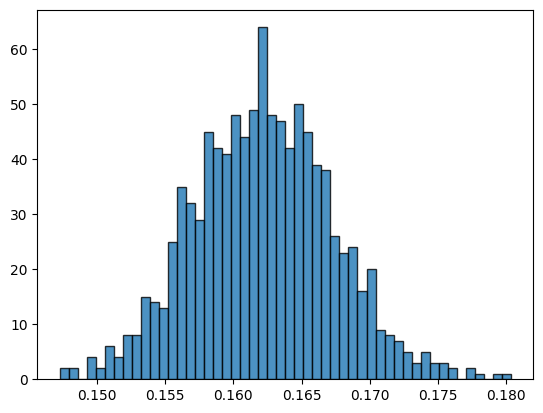

In [106]:
mod_list = []
iter = 1000

for i in range(1000):
    A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
    mod_list.append(compute_modularity(A, z_true))

print(np.mean(mod_list), np.std(mod_list))

# plot the modularity values
plt.hist(mod_list, bins=50, edgecolor="black", alpha = 0.8)
plt.show()


In [107]:
# print("Maximum value:", max(mod_list))
# print("Minimum value:", min(mod_list))

In [108]:
# mod_init_list = []
# iter = 1000

# for i in range(1000):
#     A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
#     z_0 = warm_initializer(z_true, alpha, n ,k)
#     mod_list.append(compute_modularity(A, z_0))

# print(np.mean(mod_list), np.std(mod_list))

# # plot the modularity values
# plt.hist(mod_list, bins=30)
# plt.show()

0.05472070993069468 0.004344135350131712


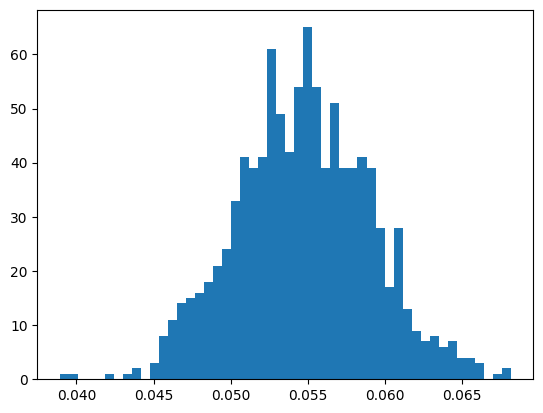

In [129]:
mod_list = []
iter = 1000
alpha = 0.3
np.random.seed(0)

A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
for i in range(1000):
    z_0 = warm_initializer(z_true, alpha, n ,k)
    mod = compute_modularity(A, z_0)
    if mod > 0.15: print("ok")
    mod_list.append(mod)


print(np.mean(mod_list), np.std(mod_list))

# plot the modularity values
plt.hist(mod_list, bins=50)
plt.show()

In [110]:
# alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

# A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)

# for alpha in alpha_values:
#     print("Alpha: ", alpha)
#     mod_init_list = []
#     iter = 500

#     for i in range(iter):
#         z_0 = warm_initializer(z_true, alpha, n, k)
#         mod_list.append(compute_modularity(A, z_0))

#     print(np.mean(mod_list), np.std(mod_list))

#     # plot the modularity values
#     plt.hist(mod_list, bins=50, edgecolor='black')
#     plt.show()

### Convergence of batched algorithm with different modularities

We define a function that constructs an initialization with a desired modularity value.
Since modularity can be computed, in matrix form, as:

$$
Q=\frac{tr(Z^T B Z)}{2m}
$$
where $m$ is the number of edges of the network and $B = A - C$ where $C_{i,j} = \frac{k_ik_j}{2m}$, $k_i$ being the dergee of the $i^{th}$ node.
From this, we get that:
$$
tr(Z^T C Z) = tr(Z^TAZ) - 2mQ
$$


In [111]:
# np.random.seed(0)
modularity_value = 0.5

def modularity_initializer(A, target_modularity, n, k):
    m = np.sum(A) // 2
    pi = np.ones(k) / k
    z = np.random.choice(a=list(range(k)), size=n, p=pi)
    Z = one_hot_encode(z)
    degrees = np.sum(A, axis=1)
    C = np.outer(degrees, degrees) / (2*m)
    lhs = np.trace(Z.T @ C @ Z)
    rhs = 2*m*target_modularity - np.trace(Z.T @ A @ Z)
    # how can we adjust it so that it matches the target modularity?

In [133]:
# we pick realizations of z with high and low modularity

# use 0.07 and 0.15 as criterions

np.random.seed(0)
A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
low_list = []
high_list = []
iter_max = 1000
length = 20
alpha = 0.3

for i in range(iter_max):
    if len(low_list) >= length and len(high_list) >= length:
        break
    z_0 = warm_initializer(z_true, alpha, n, k)
    mod = compute_modularity(A, z_0)
    if mod < 0.048 and len(low_list) < length:
        low_list.append(z_0)
    if mod > 0.062 and len(high_list) < length:
        high_list.append(z_0) 


In [138]:
len(low_list), len(high_list)

(20, 20)

In [139]:
# for all algorithms
alpha_p_pri = 1
beta_p_pri = 1  

alpha_q_pri = 1
beta_q_pri = 1

pi_pri = np.ones((n,k))/k

In [140]:
steps = 100
# now we check convergence on the low and high samples of inizializations
p_list = np.zeros((len(low_list), steps))
q_list = np.zeros((len(low_list), steps))
loss_list_batched =  np.zeros((len(low_list), steps))

for i in range(len(low_list)):
    print("Low sample: ", i+1)
    sample = low_list[i]
    # run the batched sampler
    
    batched = batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        pi_pri
                                        )
    batched.run(steps, burn_in = 0)
    z_list_batched = batched.get_z_list()
    losses_batched = [loss(z_true, z_list_batched[j])[0] for j in range(steps)]
    loss_list_batched[i, :] = losses_batched
    p_list[i, :] = batched.get_p_list()
    q_list[i, :] = batched.get_q_list()


Low sample:  0


100%|██████████| 100/100 [00:00<00:00, 118.33it/s]


Low sample:  1


100%|██████████| 100/100 [00:00<00:00, 118.51it/s]


Low sample:  2


100%|██████████| 100/100 [00:00<00:00, 121.81it/s]


Low sample:  3


100%|██████████| 100/100 [00:00<00:00, 118.43it/s]


Low sample:  4


100%|██████████| 100/100 [00:00<00:00, 109.37it/s]


Low sample:  5


100%|██████████| 100/100 [00:00<00:00, 133.30it/s]


Low sample:  6


100%|██████████| 100/100 [00:00<00:00, 121.31it/s]


Low sample:  7


100%|██████████| 100/100 [00:00<00:00, 107.91it/s]


Low sample:  8


100%|██████████| 100/100 [00:00<00:00, 109.91it/s]


Low sample:  9


100%|██████████| 100/100 [00:00<00:00, 110.72it/s]


Low sample:  10


100%|██████████| 100/100 [00:00<00:00, 133.70it/s]


Low sample:  11


100%|██████████| 100/100 [00:00<00:00, 129.72it/s]


Low sample:  12


100%|██████████| 100/100 [00:00<00:00, 131.92it/s]


Low sample:  13


100%|██████████| 100/100 [00:00<00:00, 133.96it/s]


Low sample:  14


100%|██████████| 100/100 [00:00<00:00, 121.93it/s]


Low sample:  15


100%|██████████| 100/100 [00:00<00:00, 102.07it/s]


Low sample:  16


100%|██████████| 100/100 [00:00<00:00, 116.25it/s]


Low sample:  17


100%|██████████| 100/100 [00:00<00:00, 125.51it/s]


Low sample:  18


100%|██████████| 100/100 [00:00<00:00, 115.88it/s]


Low sample:  19


100%|██████████| 100/100 [00:00<00:00, 101.65it/s]


Alpha:  0.3


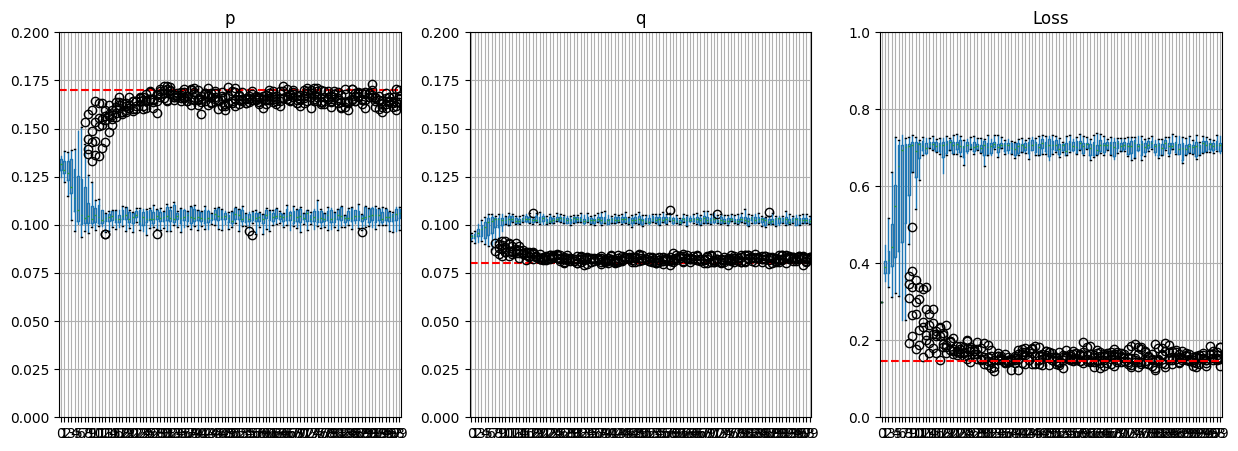

In [141]:
y_lim = 0.20
pic = False

df_p = pd.DataFrame(p_list)
df_q = pd.DataFrame(q_list)
df_loss = pd.DataFrame(loss_list_batched)
print("Alpha: ", alpha)
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.title("p")
plt.axhline(y=p, color='r', linestyle='--')
df_p.boxplot()
plt.ylim(0, y_lim)
plt.subplot(1,3,2)
plt.title("q")
plt.axhline(y=q, color='r', linestyle='--')
df_q.boxplot()
plt.ylim(0, y_lim)
plt.subplot(1,3,3)
plt.title("Loss")
df_loss.boxplot()
plt.ylim(0, 1)
plt.axhline(y=theoretical_threshold, color='r', linestyle='--')

        
if pic: plt.savefig(f'det_alpha_{alpha}_r_{r}_steps_{steps}.png')

plt.show()

In [142]:
steps = 100
# now we check convergence on the low and high samples of inizializations
p_list = np.zeros((len(high_list), steps))
q_list = np.zeros((len(high_list), steps))
loss_list_batched =  np.zeros((len(high_list), steps))

for i in range(len(high_list)):
    print("Low sample: ", i+1)
    sample = high_list[i]
    # run the batched sampler
    
    batched = batched_Gibbs_sampler(A, z_0,
                                        alpha_p_pri, beta_p_pri, 
                                        alpha_q_pri, beta_q_pri, 
                                        pi_pri
                                        )
    batched.run(steps, burn_in = 0)
    z_list_batched = batched.get_z_list()
    losses_batched = [loss(z_true, z_list_batched[j])[0] for j in range(steps)]
    loss_list_batched[i, :] = losses_batched
    p_list[i, :] = batched.get_p_list()
    q_list[i, :] = batched.get_q_list()


Low sample:  1


100%|██████████| 100/100 [00:00<00:00, 131.14it/s]


Low sample:  2


100%|██████████| 100/100 [00:00<00:00, 130.82it/s]


Low sample:  3


100%|██████████| 100/100 [00:00<00:00, 126.81it/s]


Low sample:  4


100%|██████████| 100/100 [00:00<00:00, 134.97it/s]


Low sample:  5


100%|██████████| 100/100 [00:00<00:00, 139.29it/s]


Low sample:  6


100%|██████████| 100/100 [00:00<00:00, 116.36it/s]


Low sample:  7


100%|██████████| 100/100 [00:00<00:00, 121.45it/s]


Low sample:  8


100%|██████████| 100/100 [00:00<00:00, 125.08it/s]


Low sample:  9


100%|██████████| 100/100 [00:00<00:00, 144.57it/s]


Low sample:  10


100%|██████████| 100/100 [00:00<00:00, 151.04it/s]


Low sample:  11


100%|██████████| 100/100 [00:00<00:00, 151.24it/s]


Low sample:  12


100%|██████████| 100/100 [00:00<00:00, 153.92it/s]


Low sample:  13


100%|██████████| 100/100 [00:00<00:00, 157.80it/s]


Low sample:  14


100%|██████████| 100/100 [00:00<00:00, 156.22it/s]


Low sample:  15


100%|██████████| 100/100 [00:00<00:00, 153.65it/s]


Low sample:  16


100%|██████████| 100/100 [00:00<00:00, 157.26it/s]


Low sample:  17


100%|██████████| 100/100 [00:00<00:00, 153.33it/s]


Low sample:  18


100%|██████████| 100/100 [00:00<00:00, 153.99it/s]


Low sample:  19


100%|██████████| 100/100 [00:00<00:00, 143.63it/s]


Low sample:  20


100%|██████████| 100/100 [00:00<00:00, 153.92it/s]


Alpha:  0.3


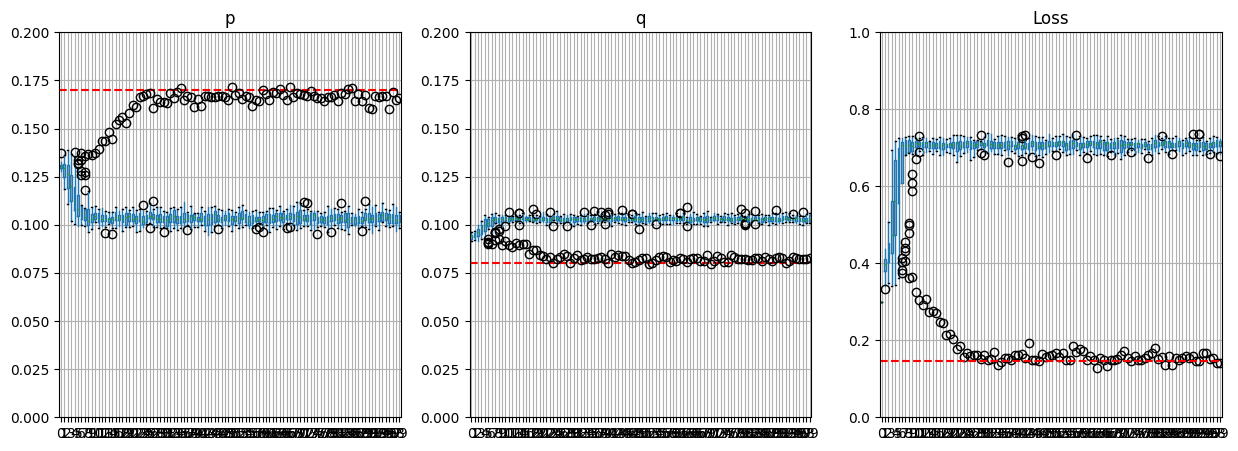

In [143]:
y_lim = 0.20
pic = False

df_p = pd.DataFrame(p_list)
df_q = pd.DataFrame(q_list)
df_loss = pd.DataFrame(loss_list_batched)
print("Alpha: ", alpha)
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.title("p")
plt.axhline(y=p, color='r', linestyle='--')
df_p.boxplot()
plt.ylim(0, y_lim)
plt.subplot(1,3,2)
plt.title("q")
plt.axhline(y=q, color='r', linestyle='--')
df_q.boxplot()
plt.ylim(0, y_lim)
plt.subplot(1,3,3)
plt.title("Loss")
df_loss.boxplot()
plt.ylim(0, 1)
plt.axhline(y=theoretical_threshold, color='r', linestyle='--')

        
if pic: plt.savefig(f'det_alpha_{alpha}_r_{r}_steps_{steps}.png')

plt.show()

## Check with true communities and random sample

In [144]:
z_0 = warm_initializer(z_true, alpha, n, k)

(array([ 3.,  2.,  1.,  1.,  5.,  1.,  4.,  7., 14.,  6., 12., 19., 20.,
        17., 27., 38., 34., 35., 43., 48., 35., 60., 39., 49., 49., 49.,
        47., 54., 38., 38., 36., 22., 34., 24., 26., 15., 17.,  7.,  8.,
         4.,  6.,  2.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.04281568, 0.04342063, 0.04402557, 0.04463051, 0.04523545,
        0.0458404 , 0.04644534, 0.04705028, 0.04765522, 0.04826016,
        0.04886511, 0.04947005, 0.05007499, 0.05067993, 0.05128487,
        0.05188982, 0.05249476, 0.0530997 , 0.05370464, 0.05430959,
        0.05491453, 0.05551947, 0.05612441, 0.05672935, 0.0573343 ,
        0.05793924, 0.05854418, 0.05914912, 0.05975406, 0.06035901,
        0.06096395, 0.06156889, 0.06217383, 0.06277878, 0.06338372,
        0.06398866, 0.0645936 , 0.06519854, 0.06580349, 0.06640843,
        0.06701337, 0.06761831, 0.06822325, 0.0688282 , 0.06943314,
        0.07003808, 0.07064302, 0.07124797, 0.07185291, 0.07245785,
        0.07306279]),
 <BarContainer

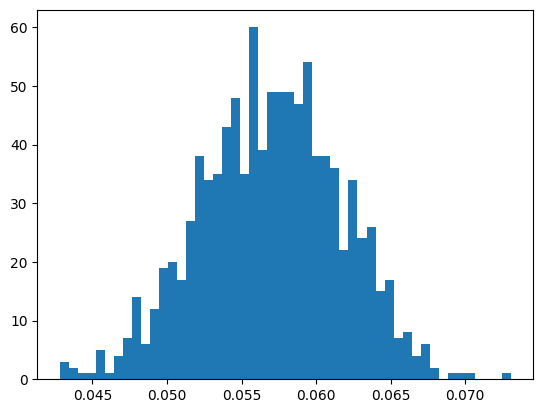

In [146]:
mod_list = []
for i in range(1000):
    A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)
    mod_list.append(compute_modularity(A, z_0))

plt.hist(mod_list, bins=50)

Slightly more variation but it's still the same, I don't see appreciable differences in convergence.